## Checkpoints Design Pattern

This notebook demonstrates how to set up checkpointing in Keras.

The model tries to predict whether or not a ride includes a toll.

### Creating dataset

Create dataset from BigQuery. The dataset consists of 19 millions rows and will not comfortably fit into memory.

In [1]:
import tensorflow as tf
from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession

def features_and_labels(features):
  label = features.pop('tolls_amount') # this is what we will train for
  return features, tf.cast(label > 0, dtypes.int64, name='threshold')

def read_dataset(client, row_restriction, batch_size=2048, infinite=True):
    GCP_PROJECT_ID='ai-analytics-solutions'  # CHANGE
    COL_NAMES = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'tolls_amount']
    COL_TYPES = [dtypes.float64] * len(COL_NAMES)
    DATASET_GCP_PROJECT_ID, DATASET_ID, TABLE_ID,  = 'bigquery-public-data.new_york.tlc_green_trips_2015'.split('.')
    bqsession = client.read_session(
        "projects/" + GCP_PROJECT_ID,
        DATASET_GCP_PROJECT_ID, TABLE_ID, DATASET_ID,
        COL_NAMES, COL_TYPES,
        requested_streams=2,
        row_restriction=row_restriction + ' AND pickup_longitude > -80 AND dropoff_longitude < -70')
    dataset = bqsession.parallel_read_rows()
    dataset = dataset.prefetch(1).map(features_and_labels).shuffle(batch_size*10).batch(batch_size)
    if infinite:
        dataset = dataset.repeat()
    return dataset

client = BigQueryClient()

In [2]:
temp_df = read_dataset(client, "pickup_datetime BETWEEN '2015-01-01' AND '2015-03-31'", 2)
for row in temp_df:
    print(row)
    break

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
(OrderedDict([('dropoff_latitude', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([40.80184555, 40.79564667])>), ('dropoff_longitude', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-73.94499207, -73.94239807])>), ('pickup_latitude', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([40.80989838, 40.81524658])>), ('pickup_longitude', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-73.95143127, -73.92116547])>)]), <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>)


In [4]:
BATCH_SIZE=2048
train_df = read_dataset(client, "pickup_datetime BETWEEN '2015-01-01' AND '2015-03-31'", BATCH_SIZE)
eval_df = read_dataset(client, "pickup_datetime BETWEEN '2015-04-01' AND '2015-04-30'", BATCH_SIZE, infinite=False) # for validation, read it only once

## Create model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



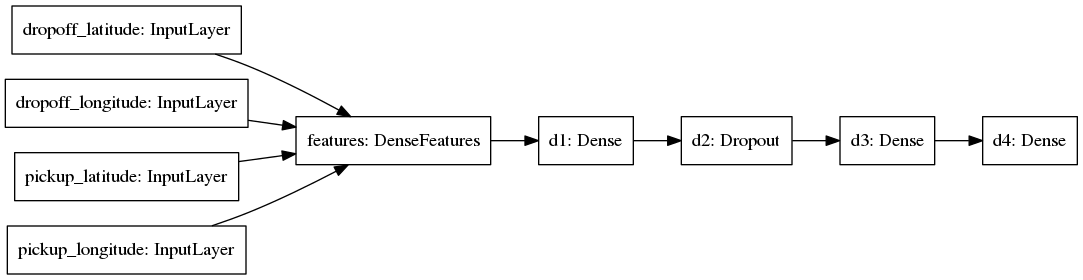

In [5]:
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='roc_auc'),
]

# create inputs, and pass them into appropriate types of feature columns (here, everything is numeric)
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float64')
    for colname in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
}
input_fc = [tf.feature_column.numeric_column(colname) for colname in inputs.keys()]

# transformations, pass through
transformed = inputs.copy()
input_layer = tf.keras.layers.DenseFeatures(input_fc, name='features')(transformed)

# Deep learning model
d1 = tf.keras.layers.Dense(16, activation='relu', name='d1')(input_layer)
d2 = tf.keras.layers.Dropout(0.25, name='d2')(d1)
d3 = tf.keras.layers.Dense(16, activation='relu', name='d3')(d2)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='d4', bias_initializer=tf.keras.initializers.Constant())(d3)

model = tf.keras.Model(inputs, output)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)
tf.keras.utils.plot_model(model, rankdir='LR')

In [8]:
class_weight = {0: 0.5, 1: 25.0}

OUTDIR='trained'
import shutil
shutil.rmtree(OUTDIR, ignore_errors=True)

NUM_TRAINING_EXAMPLES = 1000 * 1000 * 5
STOP_POINT = 3.5
TOTAL_TRAINING_EXAMPLES = int(STOP_POINT * NUM_TRAINING_EXAMPLES)
NUM_CHECKPOINTS = 10
steps_per_epoch = (TOTAL_TRAINING_EXAMPLES // 
                   (BATCH_SIZE*NUM_CHECKPOINTS))

checkpoint_path = '{}/checkpoints/taxi'.format(OUTDIR)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=False,
                                                 verbose=1)

history = model.fit(train_df, validation_data=eval_df, 
                    epochs=NUM_CHECKPOINTS,
                    steps_per_epoch=steps_per_epoch,
                    class_weight=class_weight)

Train for 854 steps
Epoch 1/10
854/854 [==============================] - 374s 438ms/step - loss: 0.6196 - accuracy: 0.9517 - precision: 0.0377 - recall: 0.0769 - roc_auc: 0.4323 - val_loss: 0.6709 - val_accuracy: 0.9809 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5004
Epoch 2/10
854/854 [==============================] - 377s 442ms/step - loss: 0.6333 - accuracy: 0.9831 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3662 - val_loss: 0.6721 - val_accuracy: 0.9809 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5004
Epoch 3/10
854/854 [==============================] - 376s 440ms/step - loss: 0.6643 - accuracy: 0.9814 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc_auc: 0.3757 - val_loss: 0.6713 - val_accuracy: 0.9809 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5004
Epoch 4/10
854/854 [==============================] - 369s 433ms/step - loss: 0.6169 - accuracy: 0.8735 - precision: 0.0265 - recall: 0.

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License